In [2]:
import jax
import optax
import distrax

import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from typing import Callable
from functools import partial
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState

from rebayes.low_rank_filter import lofi
from rebayes.utils import callbacks
from rebayes.utils.utils import tree_to_cpu
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.datasets import rotating_mnist_data as rmnist

In [307]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [308]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        return x


In [310]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(0, 1.5, n_configs)
    # angles = np.exp(t) * np.sin(35 * t)
    # angles = np.sin(35 * t) * (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
        
    # angles = np.random.randn(n_configs) * 50 + (maxangle + minangle) / 2
    angles = np.random.uniform(minangle, maxangle, size=n_configs)
    return angles

In [311]:
num_train = None
frac_train = 1.0
target_digit = 2

np.random.seed(314)
data = rmnist.load_and_transform(
    damp_angle, target_digit, num_train, frac_train, sort_by_angle=False
)

ymean, ystd = data["ymean"], data["ystd"]
X_train, Y_train, labels_train = data["dataset"]["train"]
X_test, Y_test, labels_test = data["dataset"]["test"]

In [312]:
model = MLP()
key = jax.random.PRNGKey(314)

In [313]:
initial_covariance = 1 / 2000
dynamics_weights = 1.0
dynamics_covariance = 1e-6
emission_cov = 0.01
memory_size = 10

agent_lofi, rfn = lofi.init_regression_agent(
    key, model, X_train,
    initial_covariance, dynamics_weights, dynamics_covariance,
    emission_cov, memory_size
)

In [314]:
callback = partial(callbacks.cb_reg_mc,
                   apply_fn=agent_lofi.params.emission_mean_function,
                   ymean=ymean, ystd=ystd,
                   agent=agent_lofi, X_test=X_test, y_test=Y_test,
                   key=key,
)

In [315]:
bel, output_lofi = agent_lofi.scan(X_train, Y_train, progress_bar=True, callback=callback)
bel = jax.block_until_ready(bel)

  0%|          | 0/5958 [00:00<?, ?it/s]

In [316]:
ytest = Y_test * ystd + ymean
yhattest = agent_lofi.params.emission_mean_function(bel.mean, X_test).ravel() * ystd + ymean

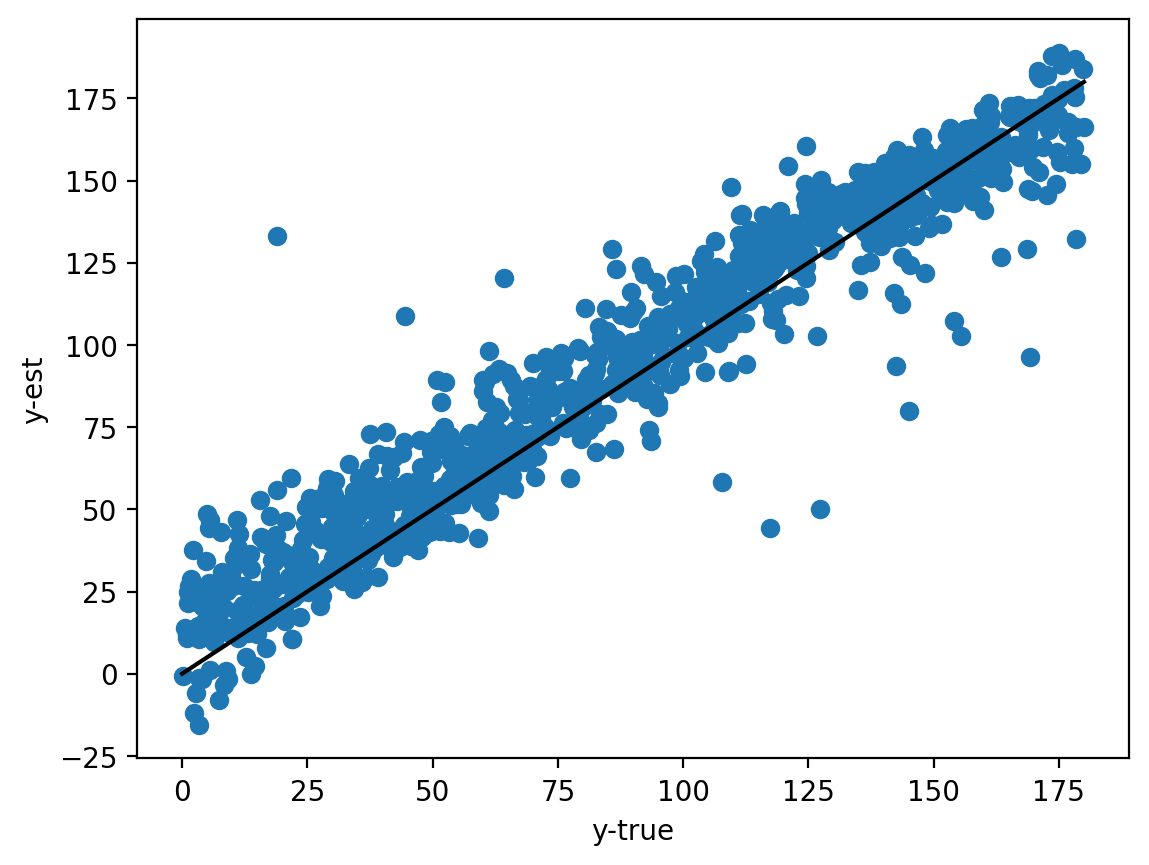

In [317]:
plt.scatter(ytest, yhattest)
plt.xlabel("y-true")
plt.ylabel("y-est")
plt.plot([0,180], [0, 180], c="black")

In [318]:
nlpd_vals = agent_lofi.nlpd_mc(key, bel, X_train[:10], Y_train[:10, None])
nlpd_vals

Array([ 3.1725,  2.8097,  2.3537,  6.7435, 35.0118,  3.764 , 63.2903,
        4.6681,  7.9144,  2.9283], dtype=float32)

In [319]:
ksize = 5
kernel = np.ones(ksize) / ksize

In [320]:
err_smooth_osa[-50:]

array([ 5.3297,  5.3046,  5.8912,  6.5106,  7.162 ,  6.7114,  7.7966,
        8.6464, 10.4025,  8.2916,  9.2409, 11.8588,  9.5106,  8.3648,
        9.5453,  7.7933,  8.6653,  8.9687,  9.9845,  9.3307, 10.6298,
        9.4939, 10.1356,  8.8025, 14.9185, 15.9025, 14.0884, 16.2095,
       15.3708, 11.2836,  8.5582,  6.6629,  5.4457,  8.5352,  7.626 ,
        8.9387, 11.1794, 10.3517,  7.3603,  5.7641,  4.5384,  2.0981,
        0.875 ,  2.5453,  3.0534,  2.8104,  4.4945,  6.8332,  6.3586,
        7.1375])

In [321]:
err_smooth_nsa[-50:]

array([14.0783, 14.0704, 14.0579, 14.046 , 14.0277, 13.9859, 13.9758,
       13.9649, 13.9517, 13.9423, 13.9385, 13.928 , 14.0051, 14.0858,
       14.1502, 14.2012, 14.2623, 14.2716, 14.2902, 14.3341, 14.395 ,
       14.4207, 14.3573, 14.2829, 14.2342, 14.2184, 14.221 , 14.2436,
       14.2651, 14.2562, 14.1968, 14.1418, 14.1247, 14.1243, 14.1668,
       14.246 , 14.3122, 14.4221, 14.5553, 14.6522, 14.7261, 14.8191,
       14.8694, 14.8869, 14.8532, 14.808 , 14.7541, 14.6794, 14.6659,
       14.6841])

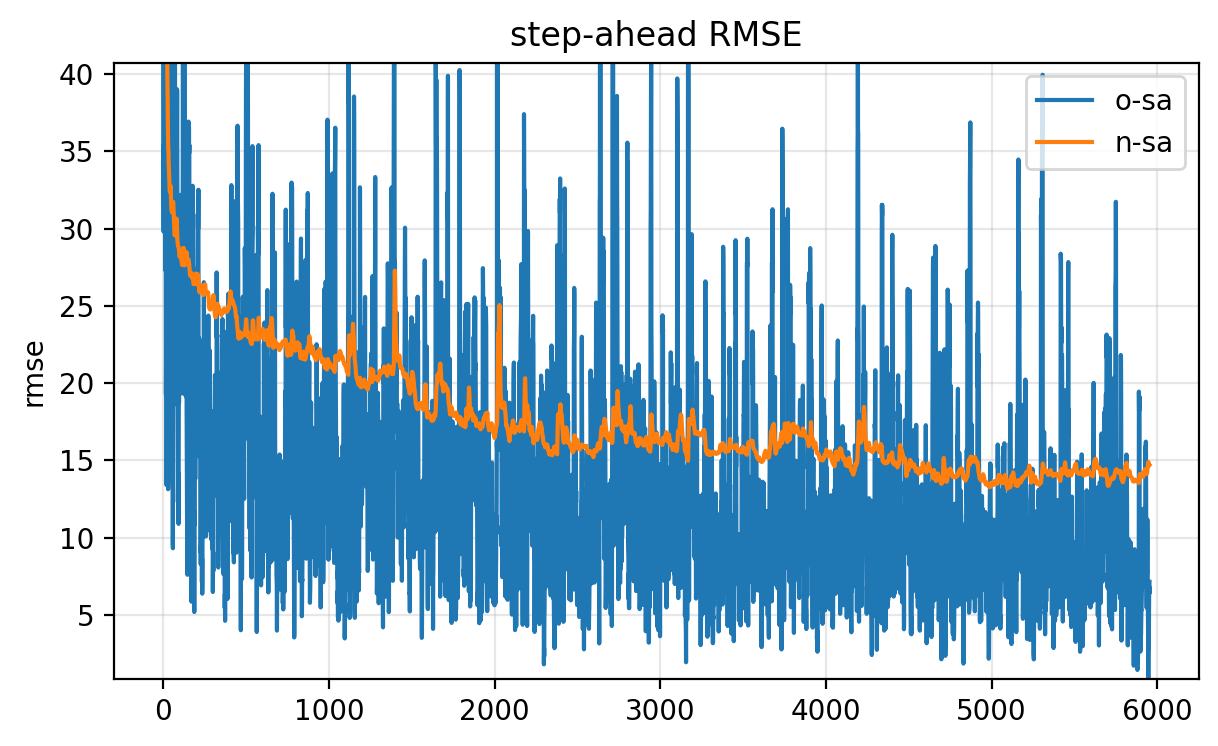

In [322]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_osa = output_lofi["osa-error"]
err_smooth_nsa = output_lofi["nsa-error"]

kmode = "valid"
err_smooth_osa = np.convolve(err_smooth_osa, kernel, mode=kmode)
err_smooth_nsa = np.convolve(err_smooth_nsa, kernel, mode=kmode)

plt.plot(err_smooth_osa, label="o-sa")
plt.plot(err_smooth_nsa, label="n-sa")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_osa, 0.00)
vmax = np.quantile(err_smooth_osa, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("step-ahead RMSE")
plt.ylim(vmin, vmax);

## Online Laplace — RSGD

In [339]:
scale = np.sqrt(emission_cov)
prior_cov = initial_covariance

@partial(jax.jit, static_argnames=("apply_fn",))
def log_likelihood(params, X, y, apply_fn):
    y = y.ravel()
    mean = apply_fn(params, X).ravel()
    ll = distrax.Normal(mean, scale).log_prob(y)
    return ll.sum()
    
@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_map(params, counter, X, y, apply_fn):
    """
    Lossfunction for regression problems.
    """
    params_flat, _ = ravel_pytree(params)
    
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    
    prior_std = jnp.sqrt(prior_cov)
    
    log_likelihood = distrax.Normal(yhat, scale).log_prob(y)
    log_likelihood = (log_likelihood * counter).sum()
    
    return -log_likelihood.sum()

In [340]:
buffer_size = 10
tx = optax.adam(1e-4)
key = jax.random.PRNGKey(314)
agent_rsgd = rsgd.init_regression_agent(
    key, log_likelihood, model, X_train, tx, buffer_size,
    lossfn=lossfn_map,
    prior_precision=1/prior_cov,
)

In [341]:
callback = partial(callbacks.cb_reg_mc,
                   apply_fn=agent_rsgd.apply_fn,
                   ymean=ymean, ystd=ystd,
                   agent=agent_rsgd, X_test=X_test, y_test=Y_test,
                   key=key,
)

In [342]:
bel, output_rsgd = agent_rsgd.scan(X_train, Y_train, progress_bar=True, callback=callback)
bel = jax.block_until_ready(bel)
output_rsgd = tree_to_cpu(output_rsgd)

  0%|          | 0/5958 [00:00<?, ?it/s]

Text(0.5, 1.0, 'step-ahead RMSE')

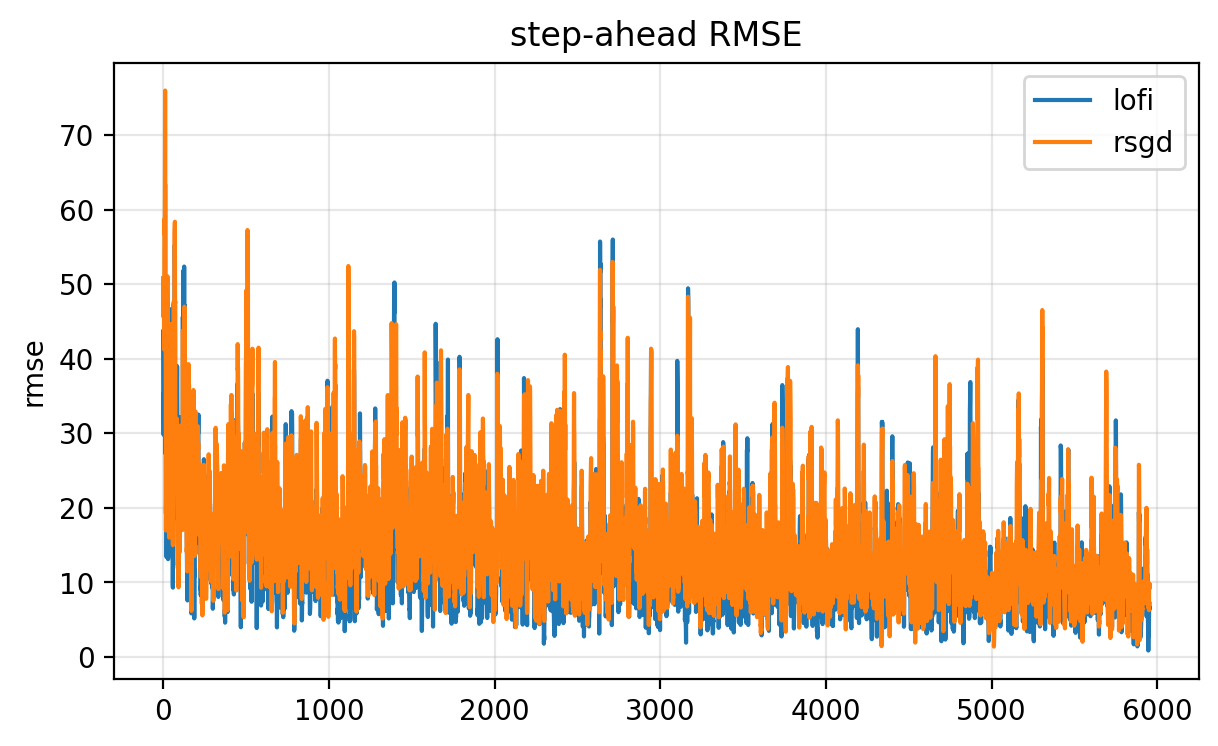

In [343]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["osa-error"]
err_smooth_rsgd = output_rsgd["osa-error"]

err_smooth_lofi = np.convolve(err_smooth_lofi, kernel, mode=kmode)
err_smooth_rsgd = np.convolve(err_smooth_rsgd, kernel, mode=kmode)

plt.plot(err_smooth_lofi, label="lofi")
plt.plot(err_smooth_rsgd, label="rsgd")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_osa, 0.00)
vmax = np.quantile(err_smooth_osa, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("step-ahead RMSE")
# plt.ylim(vmin, vmax);

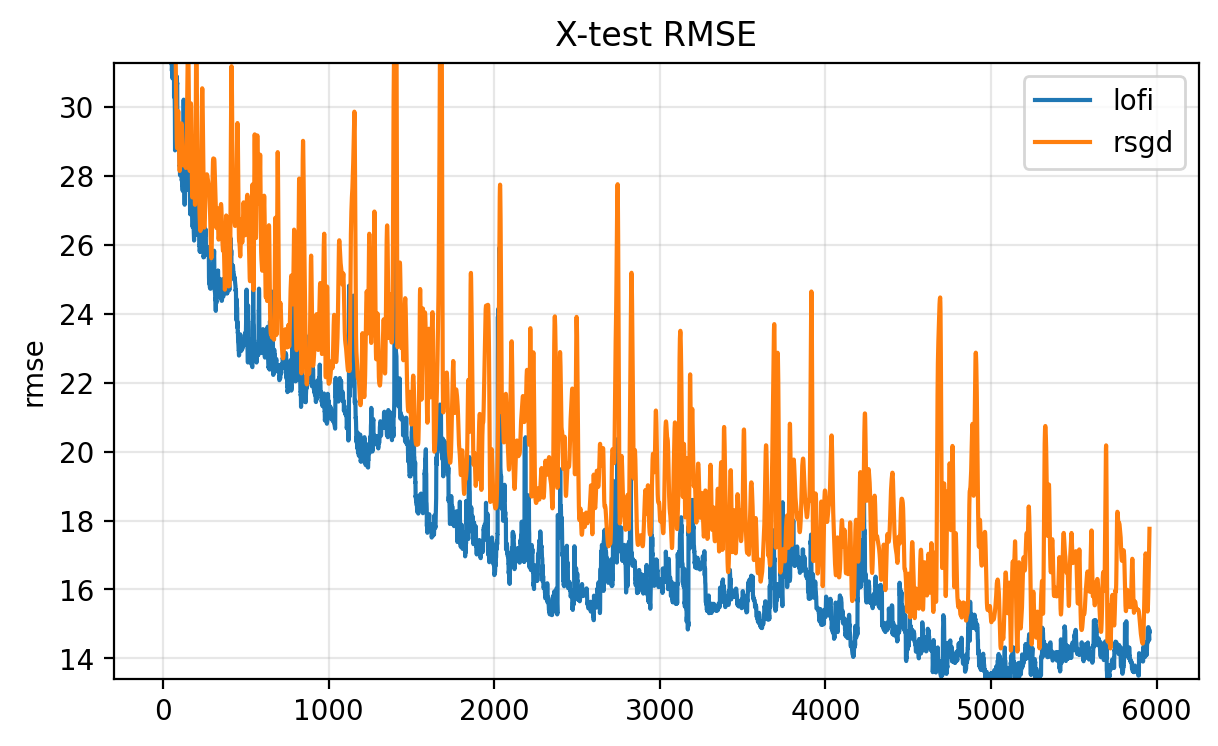

In [345]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["nsa-error"]
err_smooth_rsgd = output_rsgd["nsa-error"]

# err_smooth_lofi = np.convolve(err_smooth_lofi, kernel, mode=kmode)
# err_smooth_rsgd = np.convolve(err_smooth_rsgd, kernel, mode=kmode)

plt.plot(err_smooth_lofi, label="lofi")
plt.plot(err_smooth_rsgd, label="rsgd")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_lofi, 0.01)
vmax = np.quantile(err_smooth_lofi, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("X-test RMSE")
plt.ylim(vmin, vmax);

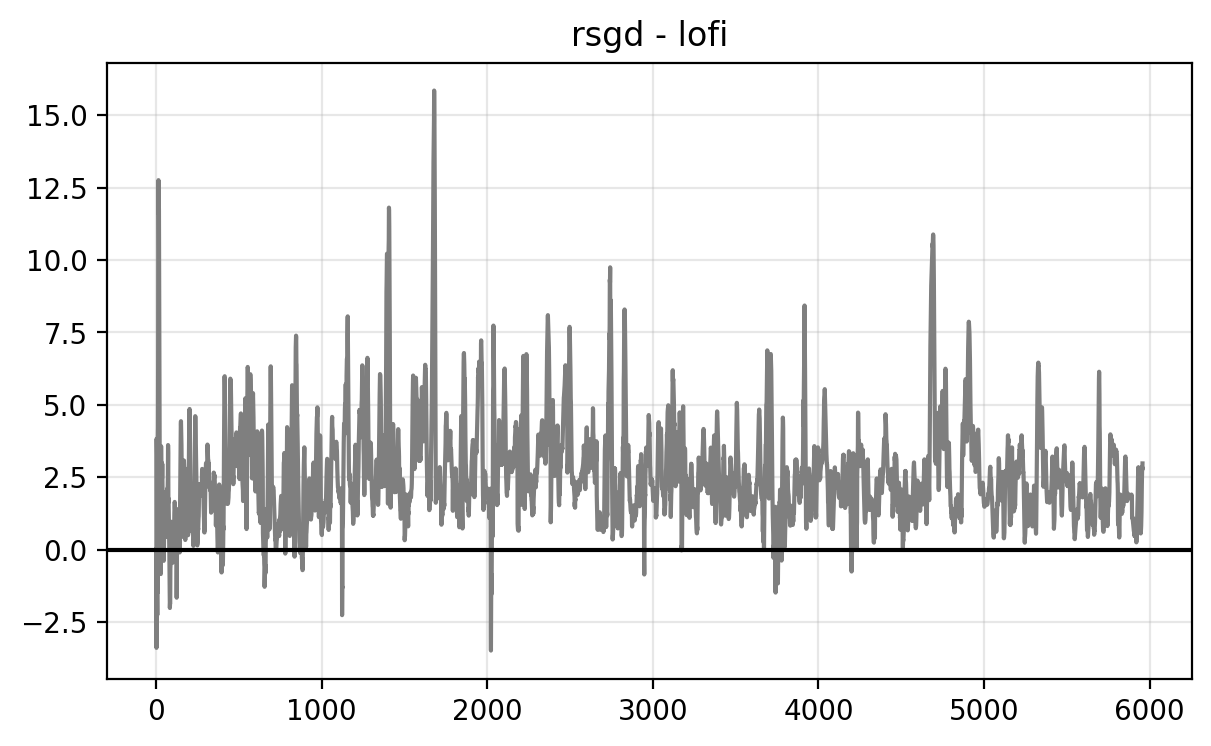

In [346]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(err_smooth_rsgd - err_smooth_lofi, c="tab:gray")
plt.axhline(y=0, c="black")
plt.title("rsgd - lofi")
plt.grid(alpha=0.3)

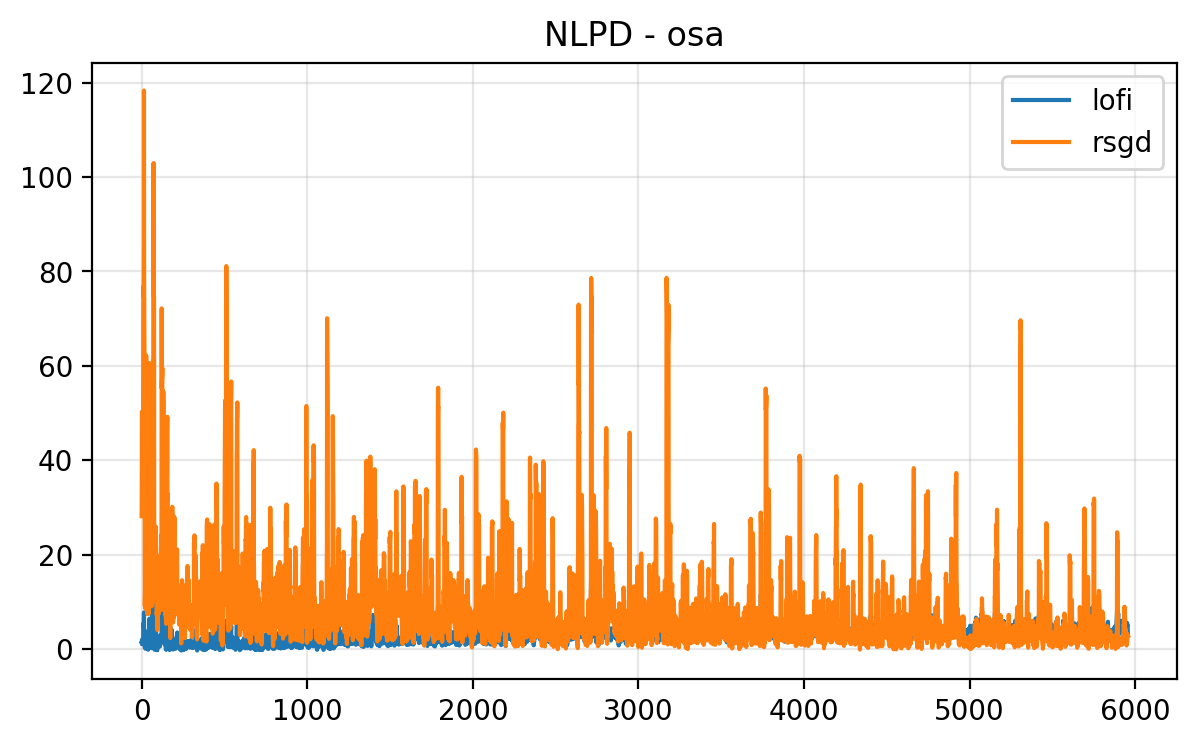

In [347]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_lofi = output_lofi["nlpd"]
metric_rsgd = output_rsgd["nlpd"]

metric_lofi = np.convolve(metric_lofi, kernel, mode="same")
metric_rsgd = np.convolve(metric_rsgd, kernel, mode="same")

plt.plot(metric_lofi, label="lofi")
plt.plot(metric_rsgd, label="rsgd")

plt.title("NLPD - osa")
plt.legend()
plt.grid(alpha=0.3)

Text(0.5, 1.0, 'X-test NLPD')

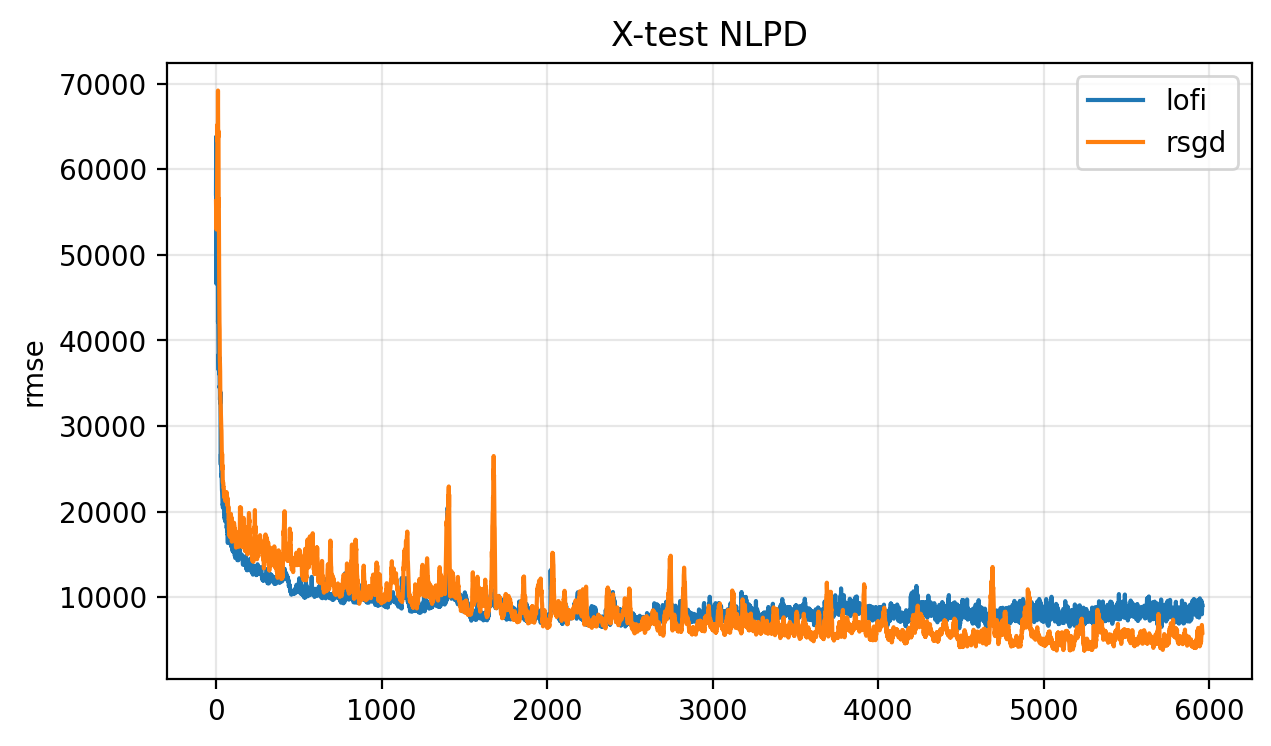

In [348]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["nlpd_test"]
err_smooth_rsgd = output_rsgd["nlpd_test"]

plt.plot(err_smooth_lofi, label="lofi")
plt.plot(err_smooth_rsgd, label="rsgd")

plt.grid(alpha=0.3)

plt.ylabel("rmse")
plt.legend()
plt.title("X-test NLPD")